## Homework 06: Student's Game Night
##### By Kevin Liu

At the lab's favorite pub, an odd bartender going by the name of *Student* challenges us to play his strange betting game.

After a few Guinness beers with Student, he loosens up and finally discloses to us that his game uniformly samples a mean $\mu$ from 21 possible choices, and a standard deviation $\sigma$ from 20 possible choices; from a normal distribution parameterized by $\mu$ and $\sigma$, Student samples $n$ numbers $x_i$, where $i=1...n$. We also learn that, depending on the game, Student may or may not tell us about the values of $\mu$ and $\sigma$. Therefore, the game is to guess where what *column* the hidden dart had hit (i.e., what the unknown mean $\mu$ is).

Before we begin to analyze Student's game and try to become an advantage player, we will first load the modules we expect to use.

In [1]:
import numpy as np
import scipy.stats as stats
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### 1. The Beginner's Game

We are first challenged to play the beginner's game, where Student tells us the value of $\sigma$ but not $\mu$. Therefore, our objective here is to figure out the value of $\mu$ given $\sigma$ and the observed data $x_1...x_n$.

For the beginner's game, we will define a series of functions to analyze the probability distributions using Student's method and Bayesian inference and to plot the distributions to estimate the unknown $\mu$ for a game with the following given parameters.

In [2]:
X          = np.array([11.50, -2.32, 9.18])  # n=3 observations.
true_sigma = 60.                             # Student also tells you this in beginner's game.
true_mu    = -20.                            # the unknown column position, mu.

mu_values  = np.linspace(-100., 100.0, 21)   # generate 21 mu values.

In [3]:
def probdist_beginner_bayes(X, true_sigma, mu_values):
    """
    Calculates the log-posterior probability for each possible values of μ.
    """
    num = np.zeros(len(mu_values)) # initialize the numerator.
    
    for i in range(len(mu_values)):
        num[i] = 0 # the prior P(μ) is uniform.
        
        # for each observation, calculate the logpdf and multiply them.
        for x in X:
            num[i] += stats.norm.logpdf(x, mu_values[i], true_sigma)
            
    post = np.exp(num - logsumexp(num)) # normalize to get the log-posterior probability.

    return post


def probdist_beginner_student(X, sigma, mu_values):
    """
    Modified based on pset provided function.
    Calculates the odds using student's method.
    
    Given an ndarray X_1..X_n, and a known sigma;
    and a list of the mu values in each column;
    return a list of the pub's inferred P(mu | X,sigma) for each column.
    """
    xbar = np.mean(X)
    N    = len(X)
    Pr   = [stats.norm.logpdf(mu, loc = xbar, scale = sigma / np.sqrt(N)) for mu in mu_values] # proportional to std error of the mean.
    Z    = logsumexp(Pr) # normalization constant.
    Pr   = np.exp([p - Z for p in Pr]) # normalization to a discrete probability distribution.
    
    return Pr


def plot_probdist_beginner(post_b, post_s, mu_values, true_mu):
    """
    Plots the pub's probability distribution and the posterior probability distribution on the same plot.
    """
    fig, ax = plt.subplots()
    ax.semilogy(mu_values, post_b, label = "Baysian", alpha = 0.5)
    ax.semilogy(mu_values, post_s, label = "Pub", alpha = 0.5)
    ax.set(xlabel = "$\mu$", ylabel = "$log(P(\mu \mid \sigma, x))$")
    ax.axvline(true_mu, color = "k", ls = "dashed", label = "True $\mu$")
    ax.legend(loc = "best")
    plt.title("Beginner's Game Posterior Distribution Curves")

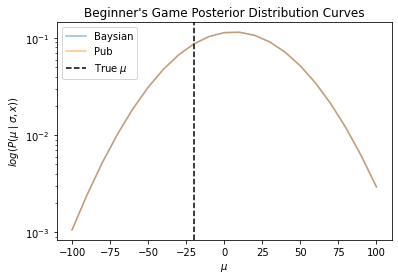

In [4]:
post_b = probdist_beginner_bayes(X, true_sigma, mu_values)
post_s = probdist_beginner_student(X, true_sigma, mu_values)
plot_probdist_beginner(post_b, post_s, mu_values, true_mu)

After inspecting our probability distribution curves, we conclude that both Student's method (Pub) and Bayesian inference method (Baysian) work equally well at inferring the unknown value of $\mu$ given $\sigma$, as both of the probability distribution curves overlap.

#### 2. The Advanced Game

Now that we've played a few rounds of the beginner's game, Student wants to increase the difficulty by not telling us neither the value of $\mu$ nor $\sigma$.

We will again define a series of functions to analyze the advanced game's probability distributions using Student's method, our Bayesian inference method, and the Student's t-distribution and demonstrate a game with the same parameters shown below as an example.

In [5]:
X            = np.array([11.50, -2.32, 9.18])  # n=3 observations.
true_sigma   = 60.                             # Student also tells you this in beginner's game.
true_mu      = -20.                            # the unknown column position, mu.

mu_values    = np.linspace(-100., 100.0, 21)   # generate 21 mu values.
sigma_values = np.linspace( 100.,   5.0, 20)   # generate 20 sigma values.

In [6]:
def probdist_advanced_bayes(X, mu_values, sigma_values):
    """
    Calculates the log-posterior probability for each of the 420 possible values of σ and μ on Student's grid.
    """
    num = np.zeros((len(sigma_values), len(mu_values))) # intialize the numerator.
    
    for i in range(len(sigma_values)):
        for j in range(len(mu_values)):
            num[i, j] = 0 # the prior P(μ) is uniform.
            
            # for each observation, calculate the logpdf and multiply them.
            for x in X:
                num[i, j] += stats.norm.logpdf(x, mu_values[j], sigma_values[i])
                
    denom = logsumexp(num) # calculate the normalization constant.
    post = num - denom # normalize to get the posterior probability.
    post_marg = np.exp(logsumexp(post, axis = 0)) # marginalize (sum over the rows).
    post = np.exp(post)
    
    return post, post_marg


def probdist_advanced_student(X, mu_values):
    """
    Modified based on pset provided function.
    Calculates the odds using pub's method.
    
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the pub's inferred P(mu | X) for each column.
    """
    xbar = np.mean(X)
    s    = np.std(X, ddof = 1) # note that numpy.std() by default calculates a population std dev; to get sample std. dev., set ddof=1.
    N    = len(X)
    Pr   = [stats.norm.logpdf(mu, loc = xbar, scale = s / np.sqrt(N)) for mu in mu_values] # proportional to std error of the mean.
    Z    = logsumexp(Pr) # normalization constant.
    Pr   = np.exp([p - Z for p in Pr]) # normalization to a discrete probability distribution.
    
    return Pr


def probdist_t(X, mu_values):
    """
    Modified based on pset provided function.
    Calculates the odds using the Student's t-distribution.
    
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column,
    according to Student's t-distribution with N-1 degrees of freedom.
    """
    N    = len(X)
    xbar = np.mean(X)
    s    = np.std(X, ddof = 1)
    t    = [(xbar - mu) / (s / np.sqrt(N)) for mu in mu_values] # t-statistic, given sample mean, sample stddev, and N.
    Pr   = [stats.t.logpdf(val, N-1) for val in t]
    Z    = logsumexp(Pr)
    Pr   = np.exp([p - Z for p in Pr])   
    return Pr


def plot_probdist_advanced(X, post_b, post_marg_b, post_s, mu_values, true_mu):
    """
    Modified based on pset provided plotting script.
    Plots the probability heatmap, the pub's probability distribution, the posterior probability distribution, and the Student's t-distribution curves on the same plot.
    """
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    
    # set up the x and y coords
    gridrows = np.linspace(100.0,   5.0, 20) # rows of the board: std. dev., sigma.
    gridcols = np.linspace(-100., 100.0, 21) # cols of the board: mean (location), mu.
  
    # format axis labels as strings, with values as "10" not "10.0" for clarity, space.
    xlabels = ["{0:.0f}".format(val) for val in gridcols]
    ylabels = ["{0:.0f}".format(val) for val in gridrows]

    sns.heatmap(post_b, ax = ax[0], 
                xticklabels = xlabels, yticklabels = ylabels, 
                cbar = False, square = True, 
                linecolor = 'grey', linewidth = 0.5)
    ax[0].set(xlabel = "$\mu$", ylabel = "$\sigma$", title = "Advanced Game Posterior Distribution Heatmap")
    
    ax[1].semilogy(mu_values, post_marg_b, color = "r", alpha = 0.5, label = "Bayesian")
    ax[1].semilogy(mu_values, post_s, color = "g", alpha = 0.5, label = "Pub")
    ax[1].semilogy(mu_values, probdist_t(X, mu_values), color = "b", alpha = 0.5, label = "t-distribution")
    ax[1].axvline(x = true_mu, color = "k", linestyle = "dashed", label = "True $\mu$")
    ax[1].legend(loc = "best", bbox_to_anchor = (1.6, 0.75))
    ax[1].set(xlabel = "$\mu$", ylabel = "$\sigma$", title = "Advanced Game Posterior Distribution Curves")
    ax[1].yaxis.tick_right()

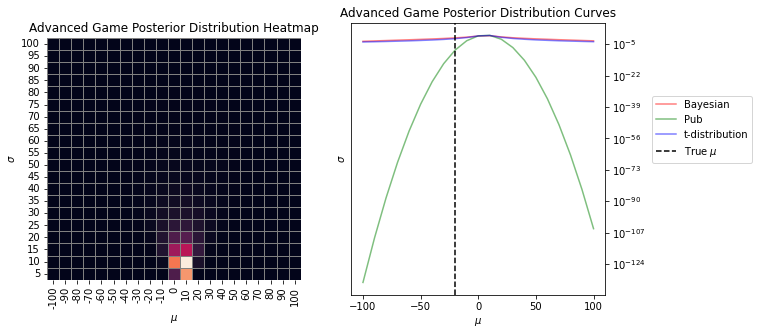

In [7]:
post_b, post_marg_b = probdist_advanced_bayes(X, mu_values, sigma_values)
post_s = probdist_advanced_student(X, mu_values)
plot_probdist_advanced(X, post_b, post_marg_b, post_s, mu_values, true_mu)

Based on our results, we can estimate (by eye-balling) that the $\mu\approx10$ and $\sigma\approx10$ based on the heatmap for the advanced game.

#### 3. Where's The Advantage?

In an attempt to become an advantage player, we will try to run Student's game script a few times to see if the pub is calculating their odds correctly and to see if we can gain an advantage with our findings.

Here, we sample game data based on the games played by 5 customers.

In [8]:
! ./student-game.py 5

Welcome to Student's game night...

The RNG seed is 46

The hidden grid has 20 rows for sigma 100.0..5.0,
                and 21 cols for mu -100.0..100.0.

Student picked grid col = 8, row = 5
and thus mu = -20.0, sigma = 75.0

Student's tea distribution machine shows the customers 5 samples:
     21.55
     -1.66
    -54.67
     -1.60
    -60.91

which give sample mean:   -19.46
   and sample std.dev.:    36.32
Figure(640x480)


In [9]:
# for a game with RNG seed 8158, we obtain the following values:
X          = np.array([-73.86, -33.04, 54.88, -83.96, -121.61])
true_sigma = 100.0
true_mu    = -60.0

mu_values  = np.linspace(-100., 100.0, 21)   # generate 21 mu values.

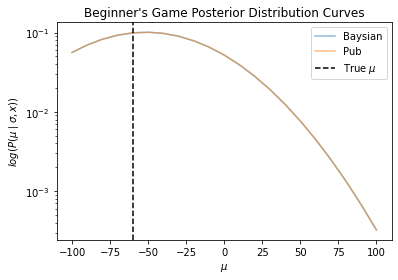

In [10]:
post_b = probdist_beginner_bayes(X, true_sigma, mu_values)
post_s = probdist_beginner_student(X, true_sigma, mu_values)
plot_probdist_beginner(post_b, post_s, mu_values, true_mu)

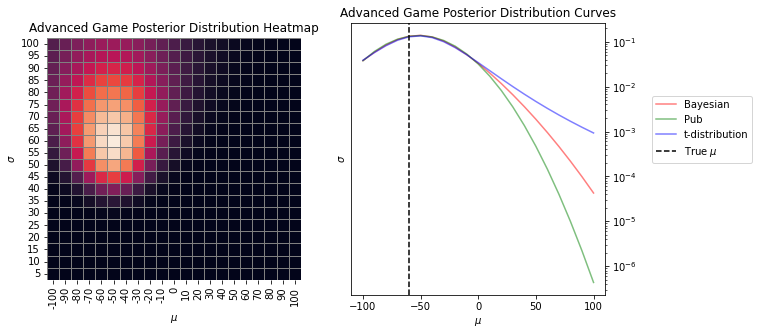

In [11]:
post_b, post_marg_b = probdist_advanced_bayes(X, mu_values, sigma_values)
post_s = probdist_advanced_student(X, mu_values)
plot_probdist_advanced(X, post_b, post_marg_b, post_s, mu_values, true_mu)

After several repetitions of analyzing these games, we can conclude that the pub's calculation of "fair" odds is actually wrong. This is evident from the deviation of the advanced game's probability distribution curves where the pub's probabilities become increasingly lower than both the Bayesian inference method and the t-distribution when we are further away from the sample mean.

Based on this observation, we can try to gain an advantage at the game by identifying situations where the pub underestimates the probability relative to our Bayesian model, which often occurs at the tails of the probability distributions, and adjusting our bets accordingly to gain a higher payout.